In [1]:
import heapq

class WeightedGraph:
    def __init__(self, nodes):
        self.graph = {}
        self.weights = {}
        for node in range(nodes):
            self.graph[node] = []
            self.weights[node] = {}

    def has_edge(self, src, dst):
        return dst in self.graph[src]

    def add_edge(self, src, dst, weight):
        if not self.has_edge(src, dst):
            self.graph[src].append(dst)
            self.graph[dst].append(src)
            self.weights[(src, dst)] = weight
            self.weights[(dst, src)] = weight
            if (dst, src) not in self.weights:
                self.weights[(dst, src)] = weight

    def get_graph(self):
        return self.graph

    def get_size(self):
        return len(self.graph) 

def initialize_distances_and_paths(graph, source):
    distances = {}
    paths = {}
    for node in graph.graph:
        distances[node] = float('inf')
        paths[node] = []
    distances[source] = 0
    paths[source] = [source]
    return distances, paths

def initialize_relax_count(graph):
    relax_count = {}
    for node in graph.graph:
        relax_count[node] = 0
    return relax_count




### Part 1.1

In [2]:
def dijkstra_k_relaxations(g, s, k):
    distances, paths = initialize_distances_and_paths(g, s)
    relax_count = initialize_relax_count(g)
    
    min_heap = [(0, s)]

    while min_heap:
        current_distance, current_node = heapq.heappop(min_heap)

        if relax_count[current_node] >= k:
            continue

        relax_count[current_node] += 1

        for neighbor in g.graph[current_node]:
            new_distance = current_distance + g.weights[(current_node, neighbor)]
            if new_distance < distances[neighbor]:
                distances[neighbor] = new_distance
                paths[neighbor] = paths[current_node] + [neighbor]
                heapq.heappush(min_heap, (new_distance, neighbor))

    return [distances, paths] 

graph = WeightedGraph(5)
graph.add_edge(0, 1, 4)
graph.add_edge(0, 2, 2)
graph.add_edge(1, 2, 3)
graph.add_edge(1, 3, 1)
graph.add_edge(2, 4, 5)
graph.add_edge(3, 4, 7)

result = dijkstra_k_relaxations(graph, 0, 2) 
print(result)

[{0: 0, 1: 4, 2: 2, 3: 5, 4: 7}, {0: [0], 1: [0, 1], 2: [0, 2], 3: [0, 1, 3], 4: [0, 2, 4]}]


### Part 1.2

In [3]:
def bellman_ford_k_relaxations(g, s, k):
    distances, paths = initialize_distances_and_paths(g, s)
    relax_count = initialize_relax_count(g)

    for _ in range(g.get_size() - 1):
        for u in g.graph:
            if relax_count[u] >= k:
                continue
            for v in g.graph[u]:
                new_distance = distances[u] + g.weights[(u, v)]
                if new_distance < distances[v]:
                    distances[v] = new_distance
                    paths[v] = paths[u] + [v]
                    relax_count[v] += 1

        for u in g.graph:
            for v in g.graph[u]:
                if distances[v] > distances[u] + g.weights[(u, v)]:
                    return None

    return [distances,paths]




In [4]:

graph = WeightedGraph(5)
graph.add_edge(0, 1, 4)
graph.add_edge(0, 2, 2)
graph.add_edge(1, 2, 3)
graph.add_edge(1, 3, 1)
graph.add_edge(2, 4, 5)
graph.add_edge(3, 4, 7)

result = bellman_ford_k_relaxations(graph, 0, 5)
print(result)

[{0: 0, 1: 4, 2: 2, 3: 5, 4: 7}, {0: [0], 1: [0, 1], 2: [0, 2], 3: [0, 1, 3], 4: [0, 2, 4]}]


## 1.3


In [30]:
import random
import networkx as nx


#inspired from https://www.geeksforgeeks.org/barabasi-albert-graph-scale-free-models/
def generate_connected_graph(n, m=2, weight_range=(1, 100), seed=None):

    G = nx.empty_graph(m)
    targets = list(range(m))
    repeated_nodes = []
    source = m
    while source < n:
        G.add_edges_from(zip([source] * m, targets))
        repeated_nodes.extend(targets)
        repeated_nodes.extend([source] * m)
        targets = random.sample(repeated_nodes, m)
        source += 1

    for u, v in G.edges():
        weight = random.randint(weight_range[0], weight_range[1])
        G[u][v]['weight'] = weight

    while nx.negative_edge_cycle(G):
        for u, v in G.edges():
            weight = random.randint(weight_range[0], weight_range[1])
            G[u][v]['weight'] = weight
    graph = WeightedGraph(n)
    for u, v in G.edges():
        graph.add_edge(u, v, G[u][v]['weight'])
    
    return graph


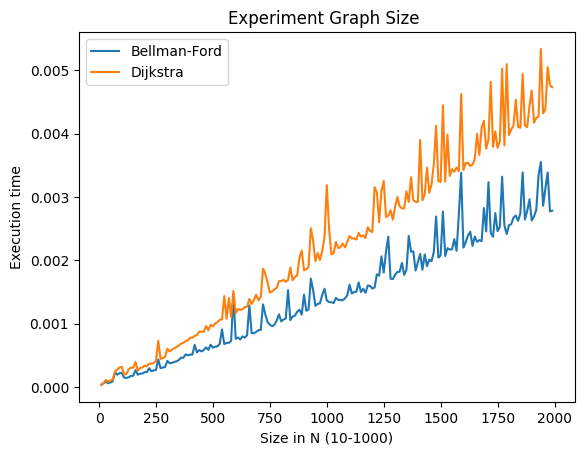

In [19]:
import timeit
import matplotlib.pyplot as plt
import numpy as np

def experiment_graph_size():

  bellman_time = []
  dijkstra_time = []

  for n in range(10, 2000, 10):
    g1 = generate_connected_graph(n)
    g2 = g1  

    # belman 
    start = timeit.default_timer()
    bellman_ford_k_relaxations(g1, 0, n-1)
    stop = timeit.default_timer()
    bellman_time.append(stop - start)

    # dijkst
    start = timeit.default_timer()
    dijkstra_k_relaxations(g2, 0, n-1)
    stop = timeit.default_timer()
    dijkstra_time.append(stop - start)


  plt.plot(np.arange(10, 2000, 10), bellman_time, label='Bellman-Ford')
  plt.plot(np.arange(10, 2000, 10), dijkstra_time, label='Dijkstra')
  plt.xlabel('Size in N (10-1000)')
  plt.ylabel('Execution time')
  plt.title('Experiment Graph Size ')
  plt.legend()
  plt.show()

experiment_graph_size()


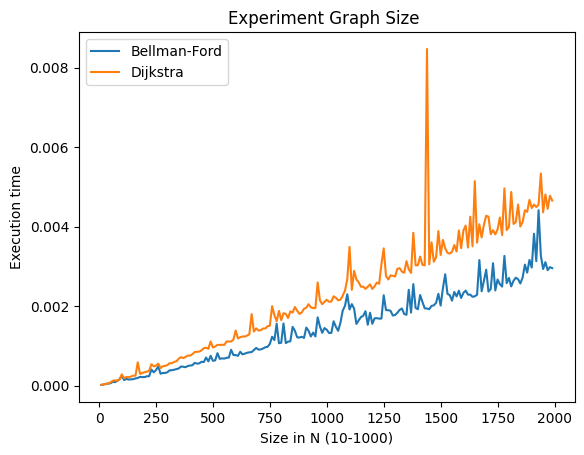

In [28]:
def experiment_graph_density():
    bellman_time = []
    dijkstra_time = []

    graph = WeightedGraph(5)
    graph.add_edge(0, 1, 4)
    graph.add_edge(0, 2, 2)

    for n in range(10, 2010, 100):
        random_node = random.randint(1, min(n-1, 4))  
        weight = random.randint(5, 10)
        graph.add_edge(0, random_node, weight)

        #belllman
        start = timeit.default_timer()
        bellman_ford_k_relaxations(graph, 0, n-1)
        stop = timeit.default_timer()
        bellman_time.append(stop - start)

        #  Dijkstra
        start = timeit.default_timer()
        dijkstra_k_relaxations(graph, 0, n-1)
        stop = timeit.default_timer()
        dijkstra_time.append(stop - start)

    # Plot the results
    plt.plot(np.arange(10, 2010, 100), bellman_time, label='Bellman-Ford')
    plt.plot(np.arange(10, 2010, 100), dijkstra_time, label='Dijkstra')
    plt.xlabel('Density from source node')
    plt.ylabel('Execution time')
    plt.title('Experiment Graph Density ')
    plt.legend()
    plt.show()

experiment_graph_size()


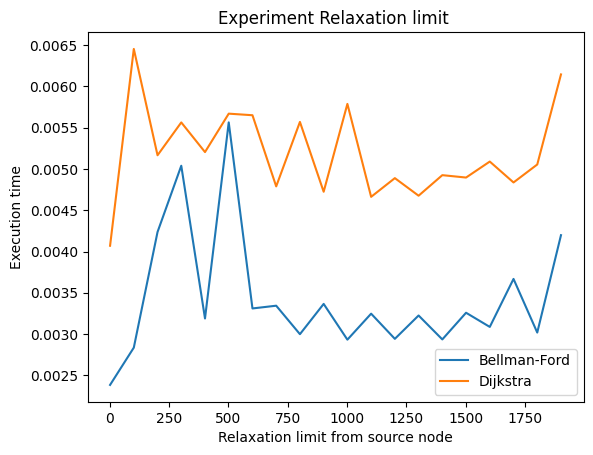

In [29]:
def experiment_graph_relaxation():
    bellman_times = []
    dijkstra_times = []
    n = 2000
    g = generate_connected_graph(n)

    for k in range(1, n, 100):
        # bellman
        start = timeit.default_timer()
        bellman_ford_k_relaxations(g, 0, k)
        stop = timeit.default_timer()
        bellman_times.append(stop - start)

        #  Dijkstra
        start = timeit.default_timer()
        dijkstra_k_relaxations(g, 0, k)
        stop = timeit.default_timer()
        dijkstra_times.append(stop - start)

    plt.plot(range(1, n, 100), bellman_times, label='Bellman-Ford')
    plt.plot(range(1, n, 100), dijkstra_times, label='Dijkstra')
    plt.xlabel('Relaxation limit from source node')
    plt.ylabel('Execution time')
    plt.title('Experiment Relaxation limit ')
    plt.legend()
    plt.show()

experiment_graph_relaxation()
